# Projeto: LinRecom 🎬

- *O `LinRecom` é um sistema de recomendação de filmes desenvolvido com base em técnicas de álgebra linear, como decomposição de matrizes e vetores de similaridade.*
- *Utilizando dados de avaliações de usuários e metadados de filmes, o projeto busca identificar padrões de preferência e gerar sugestões personalizadas com alta precisão.*
- *Este sistema combina abordagens de filtragem colaborativa e redução de dimensionalidade para revelar relações ocultas entre usuários e filmes, mesmo quando há poucos dados explícitos disponíveis.*
-  *Nesse projeto a álgebra linear entra como ferramenta fundamental para representar, transformar e extrair significado dos dados em larga escala.*

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movie-recommendation-system/movies.csv
/kaggle/input/movie-recommendation-system/ratings.csv


## 📏 Avaliação do desempenho final do Modelo
   + 📊 RMSE (Root Mean Squared Error): Mede o erro médio quadrático entre as previsões e as avaliações reais. Quanto menor, melhor. Valor alcançado: 0.7746 **(mostra boa generalização do Modelo)**
   + 📊 MAE (Mean Absolute Error):</b> Representa o erro absoluto médio entre as previsões e os valores reais. Valor alcançado: 0.5836 **(Comprova o bom desempenho do Modelo)**
   + 🎯 Precision@10: Indica a proporção de recomendações relevantes entre os 10 principais itens sugeridos. Valor atual: 0.8058 **(de cada 10 recomendações feitas pelo modelo, oito eram de fato relevantes para o usuário)**
   + 🔍 Recall@10: Mede a capacidade do sistema de recuperar itens relevantes entre os 10 principais. Valor atual: 0.5688 **(de 10 recomendações relevantes para o usuário, o modelo conseguiu identificar aproximadamente seis)**
   > Essas métricas ajudam a validar a qualidade das recomendações, garantindo que o sistema seja preciso e útil para o usuário.

![Métricas do Modelo](rmse-mae.png)
![Tempo de Treinamento](tempo-treinamento.png)
![Precision vs Recall](precision-recall.png)

In [ ]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import gc
from IPython.display import Markdown
from collections import defaultdict
import pickle
np.random.seed(3214)

In [3]:
# Função para agrupar previsões por usuário
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Ordenar e pegar os top N
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# Calcular Precision@K e Recall@K
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = []
    recalls = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in top_k)
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in top_k)

        precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    return sum(precisions) / len(precisions), sum(recalls) / len(recalls)

# 🎯 O objetivo
- *Aplicar conceitos de álgebra linear (como similaridade entre cossenos e decomposição SVD) para construir um sistema de recomendação eficiente e confiável.*
- *Gerar recomendações personalizadas com base em similaridade vetorial e projeções em espaços latentes.*
- *Utilizar similaridade de cosseno para identificar filmes e usuários semelhantes com base em padrões de avaliação.*
- *Aplicar técnicas de otimização e redução de dimensionalidade nos dados para melhorar desempenho e interpretabilidade.*
- *Avaliar o desempenho com métricas robustas como `RMSE`, `Precision@K` e `Recall@K`*

In [4]:
ratings = pd.read_csv('/kaggle/input/movie-recommendation-system/ratings.csv', engine="pyarrow")
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
movies = pd.read_csv("/kaggle/input/movie-recommendation-system/movies.csv", engine="pyarrow")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# 📑 Conhecendo o dataset

In [6]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


In [7]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [8]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [9]:
Markdown(f"""*O conjunto de dados é esparso chegando a conter um total de **{len(ratings):,.0f}** registros, ou seja,
cada nota que os usuários atribuíram aos filmes. Se não tratado, isso compromemeterá significativamente o desempenho das
análises e dos algoritmos, impossibilitando a conclusão dos mesmos. Portanto a `conversão de tipos` a seguir é essencial
para essa otimização em um ambiente com recursos computacionais limitados como o kaggle.*""")

*O conjunto de dados é esparso chegando a conter um total de **25,000,095** registros, ou seja,
cada nota que os usuários atribuíram aos filmes. Se não tratado, isso compromemeterá significativamente o desempenho das
análises e dos algoritmos, impossibilitando a conclusão dos mesmos. Portanto a `conversão de tipos` a seguir é essencial
para essa otimização em um ambiente com recursos computacionais limitados como o kaggle.*

In [10]:
ratings['userId'] = ratings['userId'].astype("int32")
ratings['movieId'] = ratings['movieId'].astype("int32")
ratings['rating'] = ratings['rating'].astype("float32")

# Essa coluna sem significância relevante também pode comprometer computacionalmente nossas análises por isso iremos removê-la
ratings.drop('timestamp', axis=1, inplace=True)
print(ratings.dtypes)

userId       int32
movieId      int32
rating     float32
dtype: object


In [11]:
ratings.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [12]:
# Conversão de tipos no dataset dos filmes (usado para identificar os nomes e gêneros dos filmes)
movies.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [13]:
movies['movieId'] = movies['movieId'].astype('int32')
movies.dtypes

movieId     int32
title      object
genres     object
dtype: object

# 📊 Análise Exploratória

In [14]:
# Criando visualizações para recomendação de filmes e insights usando os datasets de notas e filmes

# Diretório de saída do kaggle
output_dir = "/kaggle/working/"
os.makedirs(output_dir, exist_ok=True)

# Merge notas e filmes pelo movieId
df = pd.merge(ratings, movies, on="movieId" )

### Distribuição das notas atribuídas pelos usuários
*Este gráfico mostra como os usuários avaliam os filmes, de modo geral. A maioria das notas está entre 3.0 e 5.0, com picos em 3.0 e principalmente em 4.0, indicando uma tendência relativamente positiva nas avaliações.*

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


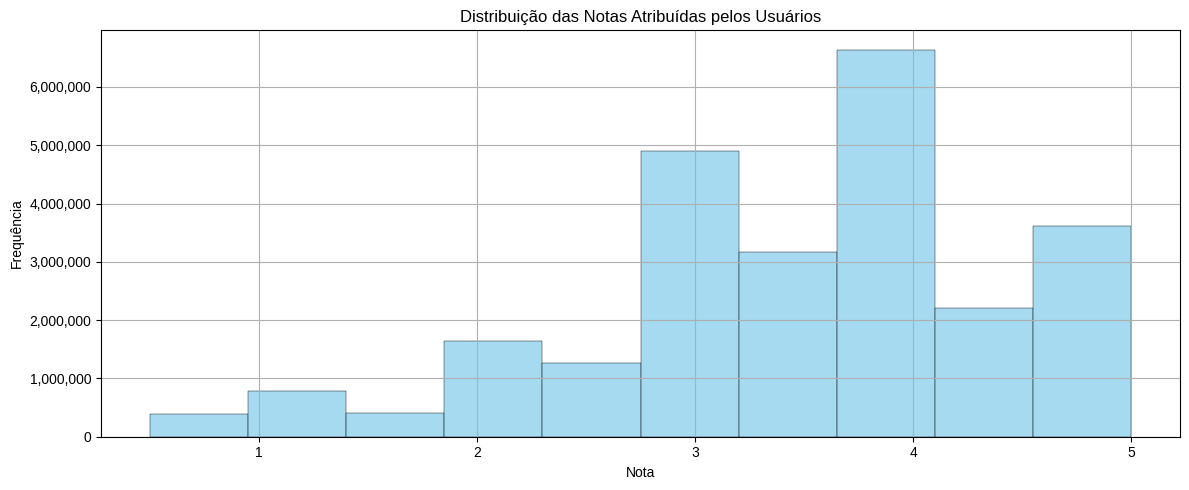

In [15]:
fig, ax = plt.subplots(figsize=(12,5))
plt.style.use('seaborn-v0_8')
sns.histplot(df['rating'], bins=10, kde=False, color='skyblue')
plt.title('Distribuição das Notas Atribuídas pelos Usuários')
plt.xlabel('Nota')
plt.ylabel('Frequência')
plt.grid(True)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.tight_layout()
plt.show()
plt.savefig(f"{output_dir}/distribuicao_notas.png")
plt.close()

### Top 10 filmes mais avaliados
*Aqui vemos os filmes com maior número de avaliações. Clássicos como `Forrest Gump`, `Pulp Fiction`, `Matrix`, `Silence of the Lambs` e `Jurassic Park`   aparecem no topo, sugerindo que são bons candidatos para recomendações baseadas em popularidade.*

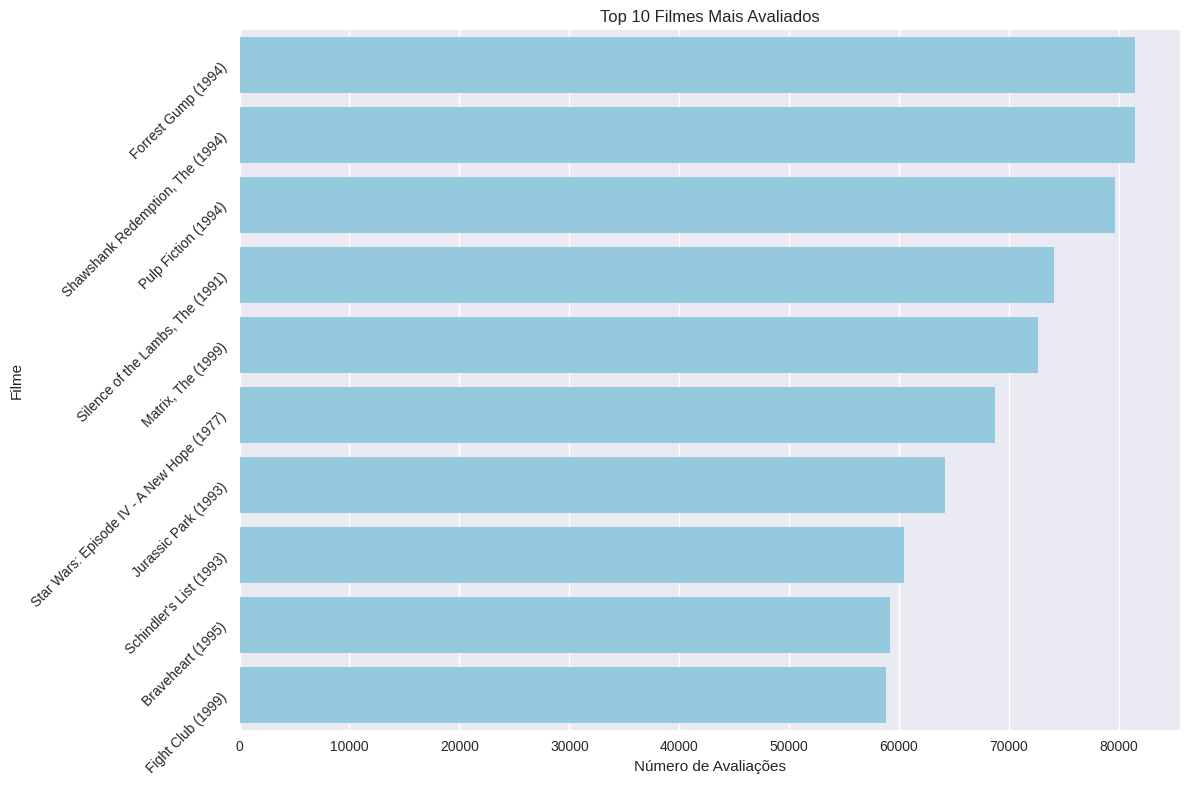

In [16]:
top_movies = df['title'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_movies.values, y=top_movies.index, color="skyblue")
plt.title('Top 10 Filmes Mais Avaliados')
plt.xlabel('Número de Avaliações')
plt.ylabel('Filme')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig(f"{output_dir}/top10_filmes_mais_avaliados.png")
plt.close()

### Distribuição do número de avaliações por filme
*A maioria dos filmes tem poucas avaliações, enquanto poucos filmes concentram muitas ***(alguns clássicos chegam a ter até 80.000 classificações)***. Essa distribuição enviesada reforça a importância de técnicas como SVD para lidar com a esparsidade dos dados.*

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


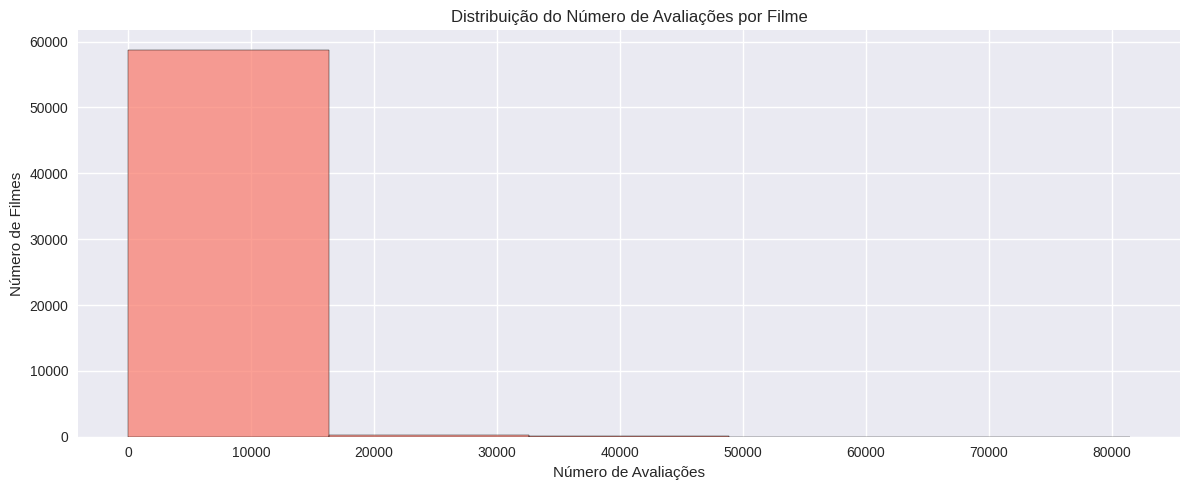

In [17]:
ratings_per_movie = df.groupby('movieId').size()
plt.figure(figsize=(12, 5))
sns.histplot(ratings_per_movie, bins=5, color='salmon', log_scale=(False, False))
plt.title('Distribuição do Número de Avaliações por Filme')
plt.xlabel('Número de Avaliações')
plt.ylabel('Número de Filmes')
plt.tight_layout()
plt.show()
plt.savefig(f"{output_dir}/distribuicao_avaliacoes_por_filme.png")
plt.close()

### Média de avaliação por gênero (filmes com pelo menos 50 avaliações)
*Ao segmentar os filmes por gênero e calcular a média de avaliação (considerando apenas filmes com pelo menos 50 avaliações), observamos que gêneros como Film-noir, Documentário, Drama e Guerra tendem a ter médias mais altas. Já Terror, filmes Infantis e Ação apresentam maior variabilidade, com avaliações mais polarizadas.*

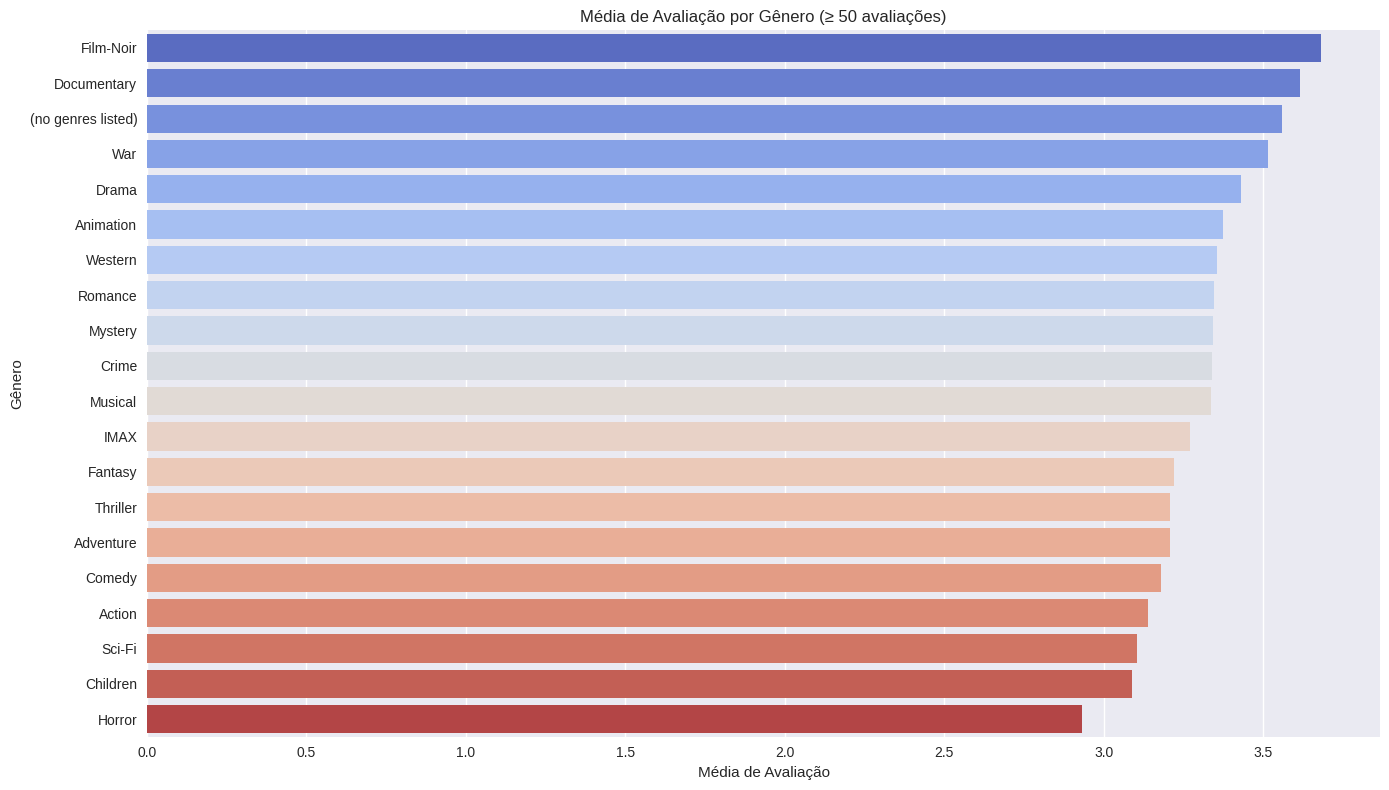

✅ Gráficos gerados com sucesso: distribuição de notas, top 10 filmes,distribuição de avaliações por filme e média por gênero.


In [18]:
movie_stats = df.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['mean_rating', 'rating_count']
movie_stats = movie_stats[movie_stats['rating_count'] >= 50]
movie_stats = movie_stats.reset_index().merge(movies, on='movieId')

# Expand genres
genre_ratings = []
for _, row in movie_stats.iterrows():
    genres = row['genres'].split('|')
    for genre in genres:
        genre_ratings.append({'genre': genre, 'mean_rating': row['mean_rating']})

genre_df = pd.DataFrame(genre_ratings)
genre_mean = genre_df.groupby('genre')['mean_rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=genre_mean.values, y=genre_mean.index, palette='coolwarm')
plt.title('Média de Avaliação por Gênero (≥ 50 avaliações)')
plt.xlabel('Média de Avaliação')
plt.ylabel('Gênero')
plt.tight_layout()
plt.show()
plt.savefig(f"{output_dir}/media_avaliacao_por_genero.png")
plt.close()

print("✅ Gráficos gerados com sucesso: distribuição de notas, top 10 filmes,"
"distribuição de avaliações por filme e média por gênero.")

In [19]:
user_counts = ratings['userId'].value_counts()
movie_counts = ratings['movieId'].value_counts()
Markdown("##### Usuário com maior atribuição de notas aos filmes: --> Id: **{}** - Total de Atribuições: **{:0,.0f}**\n"
        "##### Filme com mais atribuições de notas pelos usuários: --> **{}** - Total de Atribuições **{:0,.0f}**"
         .format(user_counts.index[0], user_counts.max(),
                 movies.loc[movie_counts.index[0]==movies['movieId']]['title'].values[0], movie_counts.max()))

##### Usuário com maior atribuição de notas aos filmes: --> Id: **72315** - Total de Atribuições: **32,202**
##### Filme com mais atribuições de notas pelos usuários: --> **Forrest Gump (1994)** - Total de Atribuições **81,491**

In [20]:
Markdown("##### Usuário com menor atribuição de notas aos filmes: --> Id: **{}** - Total de Atribuições: **{:0,.0f}**\n"
        "##### Filme com menos atribuições de notas pelos usuários: --> **{}** - Total de Atribuições **{:0,.0f}**"
         .format(user_counts.index[-1], user_counts.min(),
                 movies.loc[movie_counts.index[-1]==movies['movieId']]['title'].values[0], movie_counts.min()))

##### Usuário com menor atribuição de notas aos filmes: --> Id: **36207** - Total de Atribuições: **20**
##### Filme com menos atribuições de notas pelos usuários: --> **Il pesce innamorato (1999)** - Total de Atribuições **1**

In [21]:
# Filtrar usuários e filmes com pelo menos 1 avaliação
gc.collect()
filtered_ratings = ratings[
    ratings['userId'].isin(user_counts[user_counts >= 1].index) &
    ratings['movieId'].isin(movie_counts[movie_counts >= 1].index)
]
filtered_ratings.head(2)

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5


In [22]:
Markdown(f"##### Total de Filmes distintos no dataset original: **{ratings['movieId'].nunique():,.0f}**\n"
        f"##### Total de Usuários distintos no dataset original: **{ratings['userId'].nunique():,.0f}**")

##### Total de Filmes distintos no dataset original: **59,047**
##### Total de Usuários distintos no dataset original: **162,541**

In [23]:
Markdown(f"##### Total de Filmes distintos no dataset filtrado: **{filtered_ratings['movieId'].nunique():,.0f}**\n"
        f"##### Total de Usuários distintos no dataset filtrado: **{filtered_ratings['userId'].nunique():,.0f}**")

##### Total de Filmes distintos no dataset filtrado: **59,047**
##### Total de Usuários distintos no dataset filtrado: **162,541**

##### Isso significa que todos os usuários nesse dataset classificaram ao menos um filme e todos os filmes possuem ao menos uma classificação

# 📃 Preparação final dos dados e testes iniciais com Validação Cruzada

In [24]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(filtered_ratings[['userId', 'movieId', 'rating']], reader)

In [25]:
# Separa conjunto de dados para treino (Teste será usado apenas no final para resultados mais confiáveis)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [26]:
# Cria um Dataset artificial só com os dados de treino
train_raw_ratings = trainset.build_testset()  # converte para lista de tuplas (user, item, rating)
train_df = pd.DataFrame(train_raw_ratings, columns=['userId', 'movieId', 'rating'])
train_data = Dataset.load_from_df(train_df, reader)

In [27]:
# Deleta objetos não usados para economizar espaço em memória
try:
    del df, genre_df, genre_mean, movie_stats, train_raw_ratings, train_df
except:
    print("Objetos não encontrados no ambiente")

**No surprise, o fluxo é um pouco diferente do scikit-learn. O `cross_validate` espera um dataset cru (Dataset), não o resultado de um `train_test_split` ou `build_trainset` como os algoritmos esperam, pois todas as transformações necessárias são feitas internamente por `Cross_validate`.
Por isso criamos uma variação de `trainset` para que agora `Train_data` contenha o formato esperado por `Cross_validate`**

## Teste de Desempenho SVD (Com Cross-validation)

In [28]:
# --- Modelo: SVD ---
# Singular Value Decomposition
gc.collect() # Libera Memória
svd_model = SVD(n_factors=75,   # número de fatores latentes (default 100)
    n_epochs=30,     # número de épocas (default 20)
    lr_all=0.005,    # taxa de aprendizado
    reg_all=0.02     # regularização 
           )

In [29]:
print("Validação cruzada - SVD")
svd_results = cross_validate(svd_model, train_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Validação cruzada - SVD
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7884  0.7878  0.7869  0.7875  0.7876  0.7876  0.0005  
MAE (testset)     0.5945  0.5938  0.5932  0.5938  0.5939  0.5938  0.0004  
Fit time          370.54  389.71  390.04  391.68  391.73  386.74  8.14    
Test time         102.15  93.06   88.94   78.80   96.87   91.96   7.89    


In [30]:
svd_results

{'test_rmse': array([0.78841375, 0.78783771, 0.78685596, 0.78751469, 0.7876222 ]),
 'test_mae': array([0.59452238, 0.59381464, 0.593173  , 0.59382026, 0.59390627]),
 'fit_time': (370.538489818573,
  389.709499835968,
  390.03979778289795,
  391.67690086364746,
  391.73182106018066),
 'test_time': (102.14734649658203,
  93.05786561965942,
  88.94431328773499,
  78.80007004737854,
  96.86990880966187)}

## 📊 Interpretação dos Resultados

##### **RMSE (Root Mean Squared Error) - Média: aprox 0.7900 - Desvio padrão: 0.0005**
*O erro quadrático médio é baixo e consistente entre os folds, indicando que o modelo tem boa estabilidade e não sofre grandes variações entre diferentes divisões dos dados.*

##### **MAE (Mean Absolute Error) - Média: 0.5940 - Desvio padrão: 0.0004**
*O erro absoluto médio também é baixo e estável. Isso significa que, em média, as previsões do modelo diferem menos de 0.6 pontos da avaliação real dos usuários.*

# 🤖 Criação do Modelo Final (produção)

In [31]:
svd_model.fit(trainset)

In [32]:
uid = 1
iid = 296

In [33]:
# Teste: prever nota que o usuário 1 daria ao filme 296
prediction = svd_model.predict(uid=uid, iid=iid)
print(f"Predicted rating: {prediction.est:.2f}")

Predicted rating: 4.72


In [34]:
predictions = svd_model.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.7746
MAE:  0.5836


In [35]:
# Calcular métricas
top_n = get_top_n(predictions, n=10)
precision, recall = precision_recall_at_k(predictions, k=10, threshold=3.5)

print(f'Precision@10: {precision:.4f}')
print(f'Recall@10: {recall:.4f}')

Precision@10: 0.8058
Recall@10: 0.5688


In [36]:
with open("svd_model.pkl", "wb") as f:
    pickle.dump(svd_model, f)

## 📊 Avaliação final do Sistema de Recomendação LinRecom

## ❓ Por que essa técnica?

- **SVD:** *Prevê avaliações faltantes com alta precisão, entregando recomendações de alta qualidade.*
> ***Com isso, conseguimos estimar as avaliações que ainda não foram dadas, preenchendo os espaços vazios da matriz.***

### 🔍 Exemplo de Previsão
Para o usuário `uid = 15` e o item (filme) `iid = 17`, o modelo previu uma nota de **3.53**. Isso indica uma expectativa moderadamente positiva de avaliação, sugerindo que o usuário provavelmente gostará do filme.

### 📈 Métricas de Avaliação

As métricas utilizadas para avaliar o desempenho do modelo foram:

- **RMSE (Root Mean Squared Error):** `aprox 0.7750`  
  Mede o erro quadrático médio entre as notas reais e as previstas. Quanto menor, melhor. Um RMSE abaixo de 1 indica boa precisão nas previsões.

- **MAE (Mean Absolute Error):** `aprox 0.5840`
  Representa o erro absoluto médio. Também quanto menor, melhor. Este valor reforça a consistência do modelo.

- **Precision@10:** `aprox 0.8060`  
  Indica que, entre os 10 itens recomendados, cerca de 81.00% são relevantes (nota real acima de 3.5). Isso mostra alta qualidade nas recomendações feitas.

- **Recall@10:** `aprox 0.5690`  
  Reflete que o sistema conseguiu recuperar aproximadamente 56.90% dos itens relevantes dentro do top 10. Embora menor que a precisão, ainda é um bom resultado para sistemas de recomendação.

### 💾 Persistência do Modelo

Nesse ponto temos o modelo treinado pronto para carregamento e disponibilização via API ou serviços em nuvem.